# Amazon Find Food Reviews Modeling

### Modeling Framework
**1. Preprocess the data** <br>
**2. Split dataset into 80% training, 20% validation , 20% testing**<br>
**3. Creat sample pipeline for text feature extraction and evaluation**<br>
**4. Training different algorithms: Naive Bayes, Logistic Regression, Support Vector Machine (SVM) , Random Forest and Ada-boost classifier.  **<br>
**5. Model Eveulation and validation on the validation data set **<br>
**6. Use a grid search with cross validation to optimize on the hyperparameters of select algorithm.**<br>
**7. Test the accuracy of the model on the testing set.**

![alt](modlig processes copy.png)

In [1]:
%matplotlib inline
import numpy as np 
import pandas as pd 
from pandas import Series, DataFrame, datetime
from datetime import datetime, timedelta, time
from sklearn.model_selection import train_test_split
import nltk
import string
import matplotlib.pyplot as plt

# A size for figures
FIG_SIZE = (10,8)
# random state for classifiers
RAN_STATE = 42
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [6]:
# load data 
df = pd.read_csv('amazon_clean.csv')
df.shape

(568412, 21)

In [7]:
df.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,date_time,date,date1,year,Helpful_pct,help1,Summary1,text_Clean1,text_Clean2,word_cnt,Helpful
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,2011-04-27,2011-04-27,2011-04-27,2011,1.0,75,good quality dog food,I have bought several of the Vitality canned d...,bought several vitality canned dog food produc...,48,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,2012-09-07,2012-09-07,2012-09-07,2012,0.0,0,advertised,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled jumbo salted peanut pe...,31,0


## Data Preprocessing

+ In this classfication modeling, I want to determine if a given review text is helpful or not. So I created binary encoding to "1" helpful, "0" not helpful.
+ Here I excluded the data that has had less than 5 ratings and excluded reviews made before 2005 due to a rapidly changing business environment. In my opinion, the behavior of customers from 10 years ago may not fit the current business environment.

In [8]:
final_df= df[(df.HelpfulnessDenominator >= 5) & (df.year>=2005)]
final_df.shape

(67015, 21)

In [9]:
# for model# 
df_model=final_df[['Helpful','text_Clean2','Score']]
df_model.shape

(67015, 3)

In [10]:
# helpful reviews vs helpfulness reviews is 70% vs 30%
df_model['Helpful'].value_counts()/len(df_model)

1    0.69004
0    0.30996
Name: Helpful, dtype: float64

**Helpful VS not helpful is 70% VS 30%, it is probably no really need to balance the dataset. And we have enought data so the "class imbalance problem" doesn't arise. That's a reason I didn't apply upsampling or downsampling techniques to deal with imbalance data. **

In [11]:
# Split files into training and testing sets 80% , 20% 
from math import floor
from sklearn.utils import shuffle
# Randomize the files
df_random = shuffle(df_model)
split = 0.8
split_index = floor(len(df_random) * split)
training = df_random[:split_index]
testing = df_random[split_index:]

In [12]:
# create X, y for training and validation
X_train, X_val, y_train, y_val= train_test_split(training['text_Clean2'],
                                                   training['Helpful'], 
                                                   test_size=0.2, 
                                                   random_state=RAN_STATE)
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_val shape: {}".format(X_val.shape))
print("y_val shape: {}".format(y_val.shape))

X_train shape: (42889,)
y_train shape: (42889,)
X_val shape: (10723,)
y_val shape: (10723,)


** Total 67,422  data points for traing modeling**

## Model Training : 

### Algorithms :
**Investigate different classfication algorithms: Naive Bayes, Logistic Regression, Random Forest and Ada-boost classifier.**
+ **Naive Bayes** : Doesn't need to train prameter to tune. Easy to build up so I applied NB model as a baseline model. 
+ **Logistic Regression**: Provides probabilities for outcomes. But doesn’t perform well when feature space is too large. 
+ **SVM**  : Can model complex, nonlinear relationships and work well in the small sample sizes. 
+ **Decision Tree** : Easy to understand, visualization is very intuitive. It is not influenced by outliers and missing values to a fair degree. It also can handle both numerical and categorical variables.
+ **Random Forest** : An ensemble method in which a classifier is constructed by combining several different Independent base classifiers. Perform well on the big dataset. 
+ **Ada-boost classifier** : It is a boosting algorithm 

In [5]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.externals import joblib
from sklearn.metrics import confusion_matrix

### Baseline model : Naive Bayes  

In [30]:
count_vect = CountVectorizer(min_df = 0.01, ngram_range = (1, 1))
X_train_counts = count_vect.fit_transform(X_train)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X_new_counts = count_vect.transform(X_val)
X_val_tfidf = tfidf_transformer.transform(X_new_counts)

# y_train_b = training_b["Helpful"]
# y_val_b = testing_b["Helpful"]

prediction = dict()

x_tr = X_train_tfidf.toarray()
x_val = X_val_tfidf.toarray()

In [31]:
model_GNB = GaussianNB()
model_GNB.fit(x_tr,y_train)
train_accuracy = model_GNB.score(x_tr, y_train)
val_accuracy = model_GNB.score(x_val, y_val)
print('Gaussian Naive Bayes')
print('Accuracy on the training set: {}'.format(train_accuracy))
print('Accuracy on the validation set: {}'.format(val_accuracy))

Gaussian Naive Bayes
Accuracy on the training set: 0.7018349693394577
Accuracy on the validation set: 0.6838571295346452


In [32]:
joblib.dump(model_GNB,'GNB_clf_est.pkl')

['GNB_clf_est.pkl']

 ** Notes for diffferent text features**
 + max_features = n : only considers the top n words orderd by term frequency
 + min_df = n : ignores words with a document frequency below n
 + max_df = n : ignores words with a document frequency above n
 + TF ** IDF = Term Frequency * Inverse Document Frequency 
 + Stop_words =  ignores common words like  'the' ,  'that' ,  'which' , etc. You’ll need to define in a list what words you want to include. There are lists of common stop words available online, the NLTK library also has a list of stop words built into it.

## Sample pipeline for text feature extraction 

In [17]:
from sklearn.model_selection import StratifiedKFold
n_jobs=-1
n_folds=5
skfold = StratifiedKFold(n_splits=n_folds,random_state=RAN_STATE, shuffle=False)

In [18]:
#construct pipeline
pipeline1 = Pipeline([
    ('vect', CountVectorizer(stop_words = 'english')),
    ('tfidf', TfidfTransformer()),   
    ('clf', LogisticRegression(random_state=RAN_STATE))
                         ])
pipeline2 = Pipeline([
    ('vect', CountVectorizer(stop_words = 'english')),
    ('tfidf', TfidfTransformer()),   
    ('clf', SGDClassifier(loss='hinge',penalty='l2',max_iter=3, random_state=RAN_STATE))
                        ])

pipeline3 = Pipeline([
    ('vect', CountVectorizer(stop_words = 'english')),
    ('tfidf', TfidfTransformer()),   
    ('clf', DecisionTreeClassifier(random_state=42))
                        ])
pipeline4 = Pipeline([
    ('vect', CountVectorizer(stop_words = 'english')),
    ('tfidf', TfidfTransformer()),   
    ('clf', RandomForestClassifier(random_state=RAN_STATE))
                        ])
pipeline5= Pipeline([
    ('vect', CountVectorizer(stop_words = 'english')),
    ('tfidf', TfidfTransformer()),   
    ('clf',  AdaBoostClassifier(random_state=RAN_STATE))
                        ])

# tune parameter 
parameters1 = {'vect__ngram_range': [(1, 1),(1, 2),(1, 3)], #unigram, bigram, trigram
                   'vect__max_df': (0.25, 0.5, 0.75),
                   'clf__C': (np.logspace(-5, 1, 5))}

parameters2 = {'vect__ngram_range': [(1, 1), (1, 2),(1, 3)],
                   'vect__max_df': (0.25, 0.5, 0.75),  
                   'clf__alpha': (1e-2, 1e-3)}

parameters3 = {'vect__ngram_range': [(1, 1), (1, 2),(1, 3)],
                   'vect__max_df': (0.25, 0.5, 0.75),
                   'clf__max_depth': (3, 4, 5)}
    
parameters4 = {'vect__ngram_range': [(1, 1), (1, 2),(1, 3)],
                   'vect__max_df': (0.25, 0.5, 0.75),
                   'clf__n_estimators': [300, 500],
                   'clf__max_depth': (3, 4, 5)}
    
parameters5 = {'vect__ngram_range': [(1, 1), (1, 2),(1, 3)],
                   'vect__max_df': (0.25, 0.5, 0.75),
                   'clf__n_estimators': [300, 500]}    
    
#  gridsearch for each classfier 
gs_lr = GridSearchCV(estimator=pipeline1,
                     param_grid=parameters1,
                     n_jobs=-1,
                     scoring = 'accuracy', 
                     cv = skfold)

gs_SVC = GridSearchCV(estimator=pipeline2,
                     param_grid=parameters2,
                     n_jobs=-1,
                     scoring = 'accuracy', 
                     cv = skfold)

gs_DS = GridSearchCV(estimator=pipeline3,
                     param_grid=parameters3,
                     n_jobs=-1,
                     scoring = 'accuracy', 
                     cv = skfold)

gs_RF = GridSearchCV(estimator=pipeline4,
                     param_grid=parameters4,
                     n_jobs=-1,
                     scoring = 'accuracy', 
                     cv = skfold)

gs_Adb = GridSearchCV(estimator=pipeline5,
                     param_grid=parameters5,
                     n_jobs=-1,
                     scoring = 'accuracy', 
                     cv = skfold)  

In [19]:
gs_lr.fit(X_train,y_train)   
# Best params
print('Best params: %s' % gs_lr.best_params_)
gridsearch_best_estimator_lr = gs_lr.best_estimator_
joblib.dump(gridsearch_best_estimator_lr, 'logsitc_clf.pkl') 

Best params: {'clf__C': 10.0, 'vect__max_df': 0.5, 'vect__ngram_range': (1, 2)}


['logsitc_clf.pkl']

In [20]:
gs_SVC.fit(X_train,y_train)
print('Best params: %s' % gs_SVC.best_params_)
gridsearch_best_estimator_svm = gs_lr.best_estimator_
joblib.dump(gridsearch_best_estimator_svm, 'SVM_clf.pkl')

Best params: {'clf__alpha': 0.001, 'vect__max_df': 0.25, 'vect__ngram_range': (1, 1)}


['SVM_clf.pkl']

In [21]:
gs_RF.fit(X_train,y_train)
print('Best params: %s' % gs_RF.best_params_)
gridsearch_best_estimator_rf = gs_RF.best_estimator_
joblib.dump(gridsearch_best_estimator_rf , 'rf_clf.pkl')

Best params: {'clf__max_depth': 5, 'clf__n_estimators': 300, 'vect__max_df': 0.25, 'vect__ngram_range': (1, 3)}


['rf_clf.pkl']

In [22]:
gs_DS.fit(X_train, y_train)
print('Best params: %s' % gs_DS.best_params_)
gridsearch_best_estimator_df = gs_DS.best_estimator_
joblib.dump(gridsearch_best_estimator_df, 'ds_clf.pkl')

Best params: {'clf__max_depth': 5, 'vect__max_df': 0.25, 'vect__ngram_range': (1, 1)}


['ds_clf.pkl']

In [23]:
gs_Adb.fit(X_train,y_train)
print('Best params: %s' % gs_Adb.best_params_)
gridsearch_best_estimator_Adb = gs_Adb.best_estimator_
joblib.dump(gridsearch_best_estimator_Adb , 'adb_clf.pkl')

Best params: {'clf__n_estimators': 500, 'vect__max_df': 0.25, 'vect__ngram_range': (1, 1)}


['adb_clf.pkl']

In [34]:
gnb_clf_est1=joblib.load('GNB_clf_est.pkl') 
log_clf_est1=joblib.load('logsitc_clf.pkl')
SVM_clf_est1=joblib.load('SVM_clf.pkl')
rf_clf_est1=joblib.load('rf_clf.pkl') 
DS_clf_est1=joblib.load('ds_clf.pkl')
adb_clf_est1=joblib.load('adb_clf.pkl')

In [25]:
def roc_curve_plot(model, X, y,label=None):
    # make sure positive class prediction is in the second column of binary prediction
    if label=='Neural Network':
        y_score = model.predict_proba(X)[:,0]
    else:
        y_score = model.predict_proba(X)[:,1]
    
    # generate ROC curve data
    roc = roc_curve(y, y_score)
    
    plt.plot(roc[0], roc[1], label=label)
    plt.plot([0,1],[0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    
    roc_score = auc(roc[0],roc[1])
    print('AUC score of %s is %.2f.' % (label, roc_score))

AUC score of Gaussian Naive Bayes is 0.74.
AUC score of SVM is 1.00.
AUC score of Logistic Regression is 1.00.
AUC score of Decision Tree is 0.66.
AUC score of Random Forest is 0.81.
AUC score of AdaBoost is 0.87.


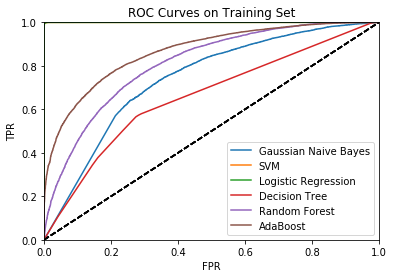

In [35]:
# plot ROC curve for each model on training set
roc_curve_plot(gnb_clf_est1, x_tr, y_train, label='Gaussian Naive Bayes')
roc_curve_plot(SVM_clf_est1, X_train, y_train, label='SVM')
roc_curve_plot(log_clf_est1, X_train, y_train, label='Logistic Regression')
roc_curve_plot(DS_clf_est1, X_train, y_train, label='Decision Tree')
roc_curve_plot(rf_clf_est1,X_train, y_train, label='Random Forest')
roc_curve_plot(adb_clf_est1, X_train, y_train, label='AdaBoost')
plt.title('ROC Curves on Training Set')
plt.legend(loc='lower right')        
plt.show()

AUC score of Gaussian Naive Bayes is 0.72.
AUC score of SVM is 0.89.
AUC score of Logistic Regression is 0.89.
AUC score of Decision Tree is 0.65.
AUC score of Random Forest is 0.77.
AUC score of AdaBoost is 0.80.


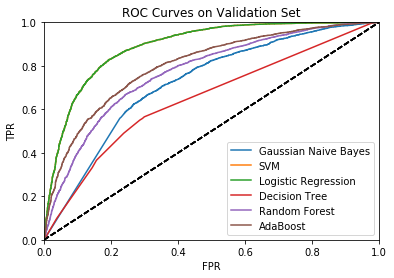

In [36]:
# plot ROC curve for each model on validation set
roc_curve_plot(gnb_clf_est1, x_val, y_val, label='Gaussian Naive Bayes')
roc_curve_plot(SVM_clf_est1,X_val, y_val, label='SVM')
roc_curve_plot(log_clf_est1, X_val, y_val, label='Logistic Regression')
roc_curve_plot(DS_clf_est1, X_val, y_val, label='Decision Tree')
roc_curve_plot(rf_clf_est1,X_val, y_val, label='Random Forest')
roc_curve_plot(adb_clf_est1, X_val, y_val, label='AdaBoost')
plt.title('ROC Curves on Validation Set')
plt.legend(loc='lower right')
plt.show()

**It seems that Logistic Regression and SVM classifier have the better modeling training result. Logistic Regression is quite a bit faster than all of other algorithms. Although SVM and Logistic regrssion have the same ROC socre, I choose Logistic Regression as the best model. 
The reasons as follows :**
+ Logistic Regression is easy to understand and interpretable. 
+ Logistic Regression is fast to train. 
+ It also shows the high accurate rate. 

## Model Eveulation & Validation:
** Matrixs to eveulation :** 
 + **Accuracy** : Classification Rate 
 + **Recall(Sensitivity):**: Recall gives us an idea about when it’s actually helpful, how often does it predict helpful.    
 + **Precision**: How many of the predicted positive samples are correctly predicted? 
 + **F-score** : (2*Recall*Precision)/(Recall+Presision)
 + **ROC/AUC **<Br>
    
**Choice of metric depends on the business goal**<Br>
We want to optimize the **"precision rate"** because if customers think reviews are helpful and will utilize the reviews more based on the review classification system, it will aid the business by increasing the conversion rate on highly rated products. Additionally, it will avoid bad shopping experiences and decrease product return rate. 

In [352]:
import itertools
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn import cross_validation

In [340]:
lr2_pipe = Pipeline([
    ('vect', CountVectorizer(stop_words = 'english',max_df= 0.5, ngram_range = (1, 2))),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(C=10)),
])

lr2_result = lr2_pipe.fit(X_train,y_train)

prediction['Logistic_Usefulness'] = lr2_pipe.predict(X_val)
print(metrics.classification_report(y_val, prediction['Logistic_Usefulness']))

             precision    recall  f1-score   support

          0       0.81      0.62      0.70      3331
          1       0.84      0.94      0.89      7392

avg / total       0.84      0.84      0.83     10723



In [341]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
 
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training samples")
    plt.ylabel("Accuracy Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="blue")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

CPU times: user 4.6 s, sys: 3.9 s, total: 8.51 s
Wall time: 6min 44s


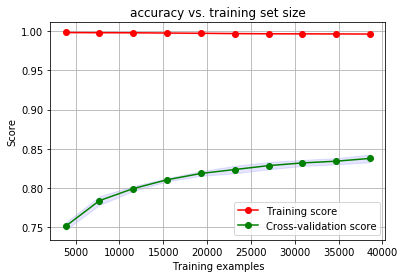

In [342]:
%time plot_learning_curve(lr2_pipe, "Learning curves with a logistic regression model", X_train, y_train, cv=10)
plt.show()

**The purpose of learning curve is to diagnose bias and variance to reduce error. ** 
+ Here we can see the training score is still around the maximum and the Cross-validation score increased with more training samples. 
+ But there still the gap between cross-validation score and training score indicates high variance scenario.
+ The solution is either reduce complexity of the model or gather more data.

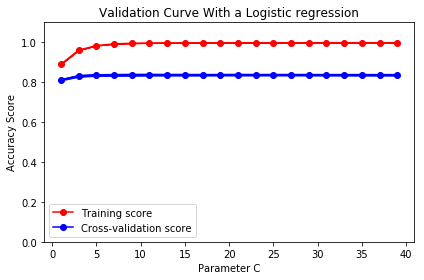

In [398]:
param_range = np.arange(1, 41, 2)

train_scores, test_scores = validation_curve(lr2_pipe,X_train, y_train, param_name="clf__C", param_range=param_range,
        cv=10, scoring="accuracy", n_jobs=1)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(param_range, train_mean,  'o-',label="Training score", color="red")
plt.plot(param_range, test_mean, 'o-',label="Cross-validation score", color="blue")

# Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="r")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="blue")


# Create plot
plt.title("Validation Curve With a Logistic regression")
plt.xlabel("Parameter C")
plt.ylabel("Accuracy Score")
plt.ylim((0.0, 1.1))
plt.tight_layout()
plt.legend(loc="best")
plt.show()

** The validation curve explores the relationship of learning factor "C" parameter to the accuracy score with 10 shuffle split cross-validation.**
+ Here the training score is high but the validation score is flat, this validation curve poses a possibility that we do not have the correct param_range to find the best parameter c. 

Confusion matrix, without normalization
[[2059 1272]
 [ 472 6920]]
Normalized confusion matrix
[[ 0.62  0.38]
 [ 0.06  0.94]]


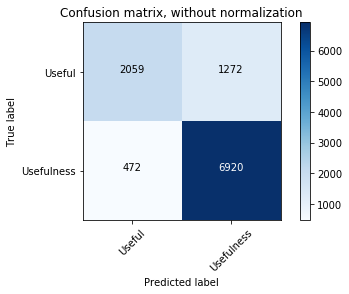

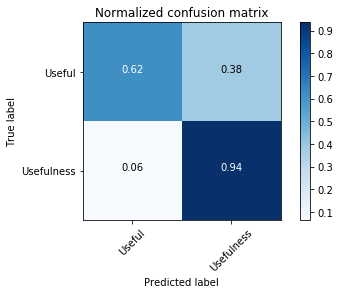

In [395]:
def plot_confusion_matrix(cm, 
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          labels=["Useful", "Usefulness"]):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix  = confusion_matrix(y_val, prediction['Logistic_Usefulness'])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, 
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Error Analysis

In [384]:
#Best params: {'clf__C': 10.0, 'vect__max_df': 0.5, 'vect__ngram_range': (1, 2)}
count_vect = CountVectorizer(stop_words = 'english', max_df= 0.5, ngram_range = (1, 2))
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [385]:
len(count_vect.get_feature_names())

887287

In [386]:
logreg = LogisticRegression(C=100,penalty='l2',tol=0.0001)
logreg_result = logreg.fit(X_train_tfidf, y_train)

In [387]:
words = count_vect.get_feature_names()
feature_coefs = pd.DataFrame(
    data = list(zip(words, logreg_result.coef_[0])),
    columns = ['feature', 'coef'])

feature_coefs.sort_values(by='coef')[0:20]

,feature,coef
877301,worst,-14.486193
217384,delicious delicious,-9.342580
57396,awful,-9.277148
795430,thought,-9.070434
351684,gross,-8.426299
723220,sorry,-8.068448
561537,passion,-8.008965
480201,maybe,-7.861484
688574,sell throw,-7.730784
584591,poison,-7.493078


In [244]:
words = count_vect.get_feature_names()
feature_coefs = pd.DataFrame(
    data = list(zip(words, logreg_result.coef_[0])),
    columns = ['feature', 'coef'])

feature_coefs.sort_values(by='coef')[-20:-1]

,feature,coef
107420,brought,8.034265
574567,picture,8.286701
464445,loved,8.388570
36725,amazed,8.440812
288493,favorite,8.766206
284504,fantastic,8.838142
710897,slightly,8.895802
581543,pleased,9.065369
373836,highly,9.275263
843218,ve,9.308090


** Let's check some cases to see if our classifier make sense **

In [246]:
print(model.predict(count_vect.transform(["My cats have been happily eating Felidae Platinum for more than two years. I just got a new bag and the shape of the food is different. They tried the new food when I first put it in their bowls and now the bowls sit full and the kitties will not touch the food. I've noticed similar reviews related to formula changes in the past. Unfortunately, I now need to find a new food that my cats will eat"])))

[1]


In [247]:
print(model.predict(count_vect.transform(["I know the product title says Molecular Gastronomy, but don't let that scare you off.  I have been looking for this for a while now, not for food science, but for something more down to earth.  I use it to make my own coffee creamer.<br /><br />I have to have my coffee blonde and sweet - but the flavored creamers are full of the bad kinds of fat, and honestly, I hate to use manufactured food items.  I really don't think they are good for the body.  On the other hand, I hate using cold milk or cream, because I like HOT coffee.<br /><br />I stumbled across this on Amazon one day and got the idea of making my own creamer.  I also bought low-fat (non-instant) milk powder and regular milk powder. The non-instant lowfat milk is a little sweeter and tastes fresher than regular instant low-fat milk, but does not dissolve good in cold water - which is not a problem for hot coffee.  You will have to play with the ratios - I would not do just the heavy cream, it made the coffee too rich. Also, I think the powder is too expensive to just use on it's own. I like mixing 1/3 of each together.<br /><br />For flavoring, I bough cocoa bean powder, vanilla bean powder, and caster (superfine) sugar.  I mix up small batches along with spices like cinnamon and nutmeg to make my own flavored creamers.  If you wanted, you could use a fake sweetner powder instead.  I make up small amounts that I store in jelly canning jars. I also use my little food chopper/food processor to blend everything, so the sugar is not heavier and sinks to the bottom.  Let it settle for a bit before opening the top though.<br /><br />This stuff tastes WAY better than the storebought creamers and it is fun to experiment and come up with your own flavors.  I am going to try using some essential oils next and see if I can get a good chocolate/orange mix.<br /><br />All of the ingredients I mentioned are here online.  Take the time to experiment.  Maybe you don't use any low-fat milk. Or don't add any flavorings.  It is up to you.  Also, would make great housewarming/host(ess) gifts.<br /><br />I am sure other molecular people will be able to tell you more of what you can do with it, and I am sure I will experiment with it in cooking - but the main reason I bought it was to make my own creamer and it worked out great"])))

[1]


In [253]:
print(model.predict(count_vect.transform(["The SALSA smelled delicious, as I think it probably was but, unfortunately, the person, at AMAZON, that is a packer there is probably several had very little stuffing to work with, especially on the bottoms.  Therefore, the bottoms were broken on all three bottles. As I reached for my computer; I was told NO RETURNS cause it's a food item.  I then looked for a CUSTOMER SERVICE tag; and I found none on their NEW FACE LIFT.  THEY SEEM TO BE PROUD OF THEIR NEW FACE LIFT BUT...THEY SHOULD AT LEAST HAVE A PLACE TO CONTACT THEM IN EMERGENCIES!  LIKE: I BUY A LOT OF STUFF AND IT ALL COMES IN STYROFOAM BOXES.  NEVER WOULD I SHIP THINGS ESPECIALLY SALSA - IN A CARDBOARD BOX WITH JUST A STRIPE OF LARGE BUBBLE WRAP ON IT.  NO MATTER HOW MUCH THE CARRIER FED EX IS CAREFUL, IT'S GOING TO BREAK SOMEWHERE ALONG THE LINE.  ESPECIALLY IN AN ALL GLASS CONTAINER!  BARBARA L. S."])))

[1]


In [256]:
print(model.predict(count_vect.transform(["the dog food is gross."])))

[0]


In [388]:
print(model.predict(count_vect.transform(["I wish it had better construction but overll not bad."])))

[0]


## Final model and optimization 

### Version 1: 

In [362]:
#Best params: {'clf__C': 10.0, 'vect__max_df': 0.5, 'vect__ngram_range': (1, 2)}
count_vect = CountVectorizer(stop_words = 'english', max_df= 0.5, ngram_range = (1, 2))
X_val_counts = count_vect.fit_transform(X_val)
tfidf_transformer = TfidfTransformer()
X_val_tfidf = tfidf_transformer.fit_transform(X_val_counts)
# y_train =  training['Helpful']

In [363]:
#make the grid search object
gs_final = grid_search.GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={'C': [10**i for i in range(-5,20)], 'class_weight': [None, 'balanced']},
    cv=cross_validation.StratifiedKFold(y_val,n_folds=10),
    scoring='roc_auc'
)

gs_final.fit(X_val_tfidf,  y_val)
val_accuracy = gs_final.score(X_val_tfidf,  y_val)
print('Accuracy on the validation set: {}'.format(val_accuracy))
print (gs_final.best_estimator_)

gridsearch_best_estimator_lr_f = gs_final.best_estimator_
joblib.dump(gridsearch_best_estimator_lr_f,'lr_clf_final.pkl')

Accuracy on the validation set: 0.9999720786693542
LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


['lr_clf_final.pkl']

**Notes** : LogisticRegression Parameters default setting 
class sklearn.linear_model.LogisticRegression (penalty=’l2’, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver=’liblinear’, max_iter=100, multi_class=’ovr’, verbose=0, warm_start=False, n_jobs=1) 

In [364]:
gs_final.grid_scores_

[mean: 0.66455, std: 0.01184, params: {'C': 1e-05, 'class_weight': None},
 mean: 0.78632, std: 0.01128, params: {'C': 1e-05, 'class_weight': 'balanced'},
 mean: 0.67640, std: 0.01144, params: {'C': 0.0001, 'class_weight': None},
 mean: 0.78634, std: 0.01129, params: {'C': 0.0001, 'class_weight': 'balanced'},
 mean: 0.73850, std: 0.00795, params: {'C': 0.001, 'class_weight': None},
 mean: 0.78654, std: 0.01132, params: {'C': 0.001, 'class_weight': 'balanced'},
 mean: 0.78466, std: 0.01005, params: {'C': 0.01, 'class_weight': None},
 mean: 0.78816, std: 0.01143, params: {'C': 0.01, 'class_weight': 'balanced'},
 mean: 0.79803, std: 0.01226, params: {'C': 0.1, 'class_weight': None},
 mean: 0.79914, std: 0.01233, params: {'C': 0.1, 'class_weight': 'balanced'},
 mean: 0.82470, std: 0.01482, params: {'C': 1, 'class_weight': None},
 mean: 0.82608, std: 0.01480, params: {'C': 1, 'class_weight': 'balanced'},
 mean: 0.83822, std: 0.01537, params: {'C': 10, 'class_weight': None},
 mean: 0.83817, s

### Version 2 : Add min_df

In [373]:
#Best params: {'clf__C': 10.0, 'vect__max_df': 0.5, 'vect__ngram_range': (1, 2)}
count_vect_n = CountVectorizer(stop_words = 'english', min_df = 0.01, max_df= 0.5, ngram_range = (1, 2))
X_val_counts1 = count_vect_n.fit_transform(X_val)
tfidf_transformer = TfidfTransformer()
X_val_tfidf1 = tfidf_transformer.fit_transform(X_val_counts1)

In [374]:
#make the grid search object
gs_final2 = grid_search.GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={'C': [10**i for i in range(-5,20)], 'class_weight': [None, 'balanced']},
    cv=cross_validation.StratifiedKFold(y_val,n_folds=10),
    scoring='roc_auc'
)

gs_final2.fit(X_val_tfidf1,  y_val)
val_accuracy1 = gs_final2.score(X_val_tfidf1,  y_val)
print('Accuracy on the validation set V2: {}'.format(val_accuracy1))
print (gs_final2.best_estimator_)

gridsearch_best_estimator_lr_f2 = gs_final2.best_estimator_
joblib.dump(gridsearch_best_estimator_lr_f2,'lr_clf_final2.pkl')

Accuracy on the validation set V2: 0.8284431204115609
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


['lr_clf_final2.pkl']

In [375]:
gs_final2.grid_scores_

[mean: 0.65875, std: 0.00741, params: {'C': 1e-05, 'class_weight': None},
 mean: 0.74525, std: 0.01021, params: {'C': 1e-05, 'class_weight': 'balanced'},
 mean: 0.66881, std: 0.00673, params: {'C': 0.0001, 'class_weight': None},
 mean: 0.74534, std: 0.01027, params: {'C': 0.0001, 'class_weight': 'balanced'},
 mean: 0.71867, std: 0.00423, params: {'C': 0.001, 'class_weight': None},
 mean: 0.74596, std: 0.01042, params: {'C': 0.001, 'class_weight': 'balanced'},
 mean: 0.75049, std: 0.00911, params: {'C': 0.01, 'class_weight': None},
 mean: 0.75102, std: 0.01113, params: {'C': 0.01, 'class_weight': 'balanced'},
 mean: 0.76558, std: 0.01323, params: {'C': 0.1, 'class_weight': None},
 mean: 0.76604, std: 0.01339, params: {'C': 0.1, 'class_weight': 'balanced'},
 mean: 0.77128, std: 0.01440, params: {'C': 1, 'class_weight': None},
 mean: 0.77093, std: 0.01428, params: {'C': 1, 'class_weight': 'balanced'},
 mean: 0.76115, std: 0.01471, params: {'C': 10, 'class_weight': None},
 mean: 0.76075, s

+ **I tried to add the min_df (minimum document frequency) to 0.01, meaning that ignore terms that appear in less than 1% of the documents. But add this cartier won't improve the model performance. ** <br>
+ ** We can see the our optimized classifier is a LogisticRession with a 'C' parameter of 10 and a 'class_weight' = 'balanced'.**

## Final Model 

In [207]:
len(testing)

13403

In [389]:
lr_final_pipe = Pipeline([
    ('vect', CountVectorizer(stop_words = 'english',max_df= 0.5, ngram_range = (1, 2))),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(C=10,tol=0.0001)),
])

lr_final_result = lr_final_pipe.fit(X_train,y_train)

prediction['Logistic_Usefulness_final'] = lr_final_pipe.predict(X_final_test)
print(metrics.classification_report(y_final_test, prediction['Logistic_Usefulness_final']))

             precision    recall  f1-score   support

          0       0.81      0.62      0.70      4148
          1       0.85      0.93      0.89      9255

avg / total       0.83      0.84      0.83     13403



** The final F1 score is equal to 0.83 and the precision and recall are also very close . It indicates our model has a good balance between sensitivity and specificity. ** 

In [390]:
joblib.dump(lr_final_pipe,'LR_final.pkl')
log_clf_final=joblib.load('LR_final.pkl')

In [393]:
random_numbers = range(1,101)
tot = 0.0
for seed in random_numbers:
    lr_final_pipe.fit(X_train,y_train)
    probas =lr_final_pipe.predict_proba(X_final_test)
    tot += roc_auc_score(y_test, probas[:,1].T)
    
print ('Average ROC_AUC Score for 1-100 random_state: {:.4f}'.format(tot/100))

Average ROC_AUC Score for 1-100 random_state: 0.8890


** The average ROC_AUC score for 100 different random_states is equal to 0.8890, the same as our optimum solution. We can consider this model is robust. **

AUC score of Logistic Regression is 0.89.


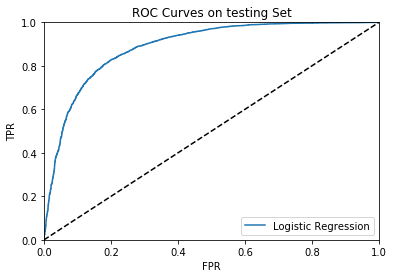

In [391]:
roc_curve_plot(log_clf_final, X_final_test, y_final_test, label='Logistic Regression')
plt.title('ROC Curves on testing Set')
plt.legend(loc='lower right')
plt.show()

# Conclusion: 
+ We observe that the area under the curve(AUC) is equal to 0.89.  
+ The result shows that our Logistic Regression model has better performance to distinguish helpful and not helpful reviews. 

## References : 
+ http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
+ http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
+ http://frnsys.com/ai_notes/machine_learning/model_selection.html
+ https://www.geeksforgeeks.org/confusion-matrix-machine-learning/
+ https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/